# TEAM C - Bike Sharing Prediction

## Content:
1. [Loading data](#load)
2. [Exploratory Data Analysis](#eda)
    1. [Data visualisation](#vis)
    2. [Duplicates](#duplicates)
    3. [Data correctness](#correctness)
    4. [Outliers](#outlier)
    5. [Correlations](#corr)
3. [Machine Learning (Predictive Analytics)](#ml)
    1. [Linear model: ElasticNet](#linear)
    2. [Tree-based model: Decision Tree](#tree)
    3. [Tree-based model: Random Forest](#forest)
    5. [Iterations: Random Forest](#iteration)
4. [Work description](#work)

## Loading data and libraries <a id=load>

In [1]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt
from joblib import dump, load

from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.linear_model import ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error as mse
from sklearn.pipeline import Pipeline

from custom_transformations import AddNewFeatures, DropColumns, Dummification

In [2]:
path = 'bike-sharing-dataset'
hour = pd.read_csv(os.path.join(path, 'hour.csv'))

# changing dtypes of columns
hour['dteday'] = pd.to_datetime(hour['dteday'], format='%Y-%m-%d')
hour[['season', 'mnth','hr','weekday', 'weathersit']] = hour[['season', 'mnth','hr','weekday', 'weathersit']].astype('object')

# setting dteday as index
hour.set_index('dteday', inplace=True)

# drop ids
hour.drop('instant', axis=1, inplace=True)

# train and test sets
train_hour = hour.loc[:'2012-09-30']
test_hour = hour.loc['2012-10-01':]

## Exploratory Data Analysis <a id='eda'>

### Data visualization <a id='vis'>

First, let's print the first 5 rows to see what information we have

In [4]:
train_hour

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
dteday,,,,,,,,,,,,,,,
2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
2011-01-01,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,1
2011-01-01,1,0,1,6,0,6,0,1,0.22,0.2727,0.80,0.0000,2,0,2
2011-01-01,1,0,1,7,0,6,0,1,0.20,0.2576,0.86,0.0000,1,2,3
2011-01-01,1,0,1,8,0,6,0,1,0.24,0.2879,0.75,0.0000,1,7,8


Some of the values, like "mnth", "hr" and "weekday" that look numerical from the table above are actually categorical in nature. It can't be said that "hr" 23 is better than 22 or 1. Hence, we modified those variables to dtype='object'. Let's verify the dtypes of columns:

In [5]:
train_hour.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15211 entries, 2011-01-01 to 2012-09-30
Data columns (total 15 columns):
season        15211 non-null object
yr            15211 non-null int64
mnth          15211 non-null object
hr            15211 non-null object
holiday       15211 non-null int64
weekday       15211 non-null object
workingday    15211 non-null int64
weathersit    15211 non-null object
temp          15211 non-null float64
atemp         15211 non-null float64
hum           15211 non-null float64
windspeed     15211 non-null float64
casual        15211 non-null int64
registered    15211 non-null int64
cnt           15211 non-null int64
dtypes: float64(4), int64(6), object(5)
memory usage: 1.9+ MB



Second, let's print basic statistics of numerical values to understand the distribution of numerical columns. 

In [6]:
train_hour.describe()

,yr,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,cnt
count,15211.000000,15211.000000,15211.000000,15211.000000,15211.000000,15211.000000,15211.000000,15211.000000,15211.000000,15211.000000
mean,0.431661,0.026625,0.684768,0.512675,0.489217,0.624933,0.191523,36.238577,148.986654,185.225232
std,0.495324,0.160991,0.464624,0.195882,0.174786,0.195718,0.122334,49.430405,146.921788,177.918222
min,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,0.340000,0.333300,0.470000,0.104500,4.000000,33.000000,39.000000
50%,0.000000,0.000000,1.000000,0.540000,0.500000,0.620000,0.194000,17.000000,112.000000,138.000000
75%,1.000000,0.000000,1.000000,0.660000,0.621200,0.780000,0.253700,50.000000,213.000000,275.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


Third, let's analyze the importance of the categorical features on our target. 

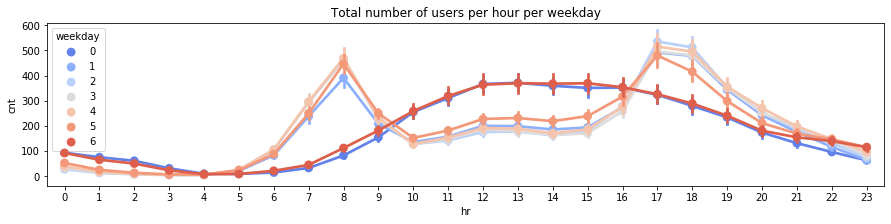

In [7]:
plt.figure(figsize=(15, 3))
ax = sns.pointplot(data=train_hour, x='hr', y='cnt', hue='weekday', palette='coolwarm')
ax.set(title='Total number of users per hour per weekday')
plt.show()

#### Comments
Seems like Weekdays 0 and 6 have different behavior than other days. Given that this is dataset from US, weekdays 0 and 6 represent Sunday and Saturday respectively. Hence, we can see that weekends differ from working days in terms of daily demand. It might be related to different use cases of bike: during working days people tend to use bikes in the morning from 6 to 9 and evening from 17:00 to 19:00 as if they were using bikes to get to and from work on regular basis. 

If this hypothesis is true, then we'd expect to see high demand during working days from registered users, while during weekends we would expect more demand from casual users. Let's check this hypothesis by plotting usage per each type of user.

We see higher demand from casual users during weekend as expected! 

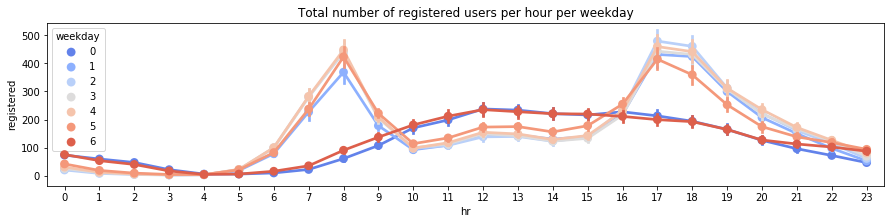

In [10]:
plt.figure(figsize=(15,3))
ax = sns.pointplot(data=train_hour, x='hr', y='registered', hue='weekday', palette='coolwarm')
ax.set(title = 'Total number of registered users per hour per weekday')
plt.show()

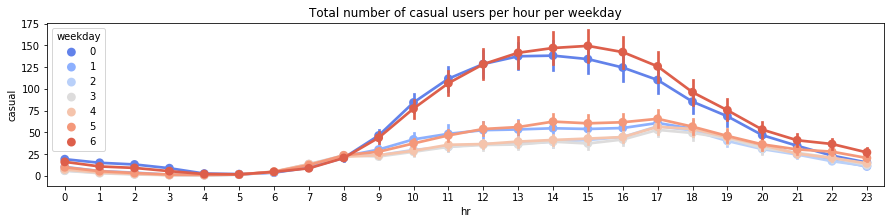

In [11]:
plt.figure(figsize=(15,3))
ax = sns.pointplot(data=train_hour, x='hr', y='casual', hue='weekday', palette='coolwarm')
ax.set(title = 'Total number of casual users per hour per weekday')
plt.show()

As we see higher demand from registered users during working days! 

Forth, let's how usage changes per year and per season. 

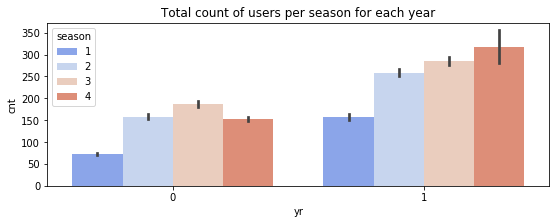

In [12]:
plt.figure(figsize=(9, 3))
ax = sns.barplot('yr','cnt', hue='season', palette='coolwarm', data=train_hour)
ax.set(title='Total count of users per season for each year')
plt.show()

### Duplicates <a id='duplicates'>

In [13]:
duplicate_rows = train_hour[train_hour.duplicated()]
duplicate_rows

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
dteday,,,,,,,,,,,,,,,
2011-12-10,4,0,12,6,0,6,0,1,0.24,0.2576,0.65,0.1045,1,10,11
2012-07-31,3,1,7,4,0,2,1,1,0.66,0.6061,0.83,0.0896,0,6,6


Let's drop these duplicate rows

In [3]:
# Removing duplicates:
train_hour = train_hour.drop_duplicates()
duplicate_rows = train_hour[train_hour.duplicated()]
duplicate_rows

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
dteday,,,,,,,,,,,,,,,


### Data Correctness <a id='correctness'>
    
Let's verify the correctness of values for categorical features by printing all unique values

In [14]:
print("Hour values:", train_hour['hr'].unique())
print('Weekday values:', train_hour['weekday'].unique())
print('Month values:', train_hour['mnth'].unique())
print('Year values:', train_hour['yr'].unique())
print('Season values:', train_hour['season'].unique())
print('Weather values:', train_hour['weathersit'].unique())

Hour values: [0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Weekday values: [6 0 1 2 3 4 5]
Month values: [1 2 3 4 5 6 7 8 9 10 11 12]
Year values: [0 1]
Season values: [1 2 3 4]
Weather values: [1 2 3 4]


### Outliers <a id='outlier'>

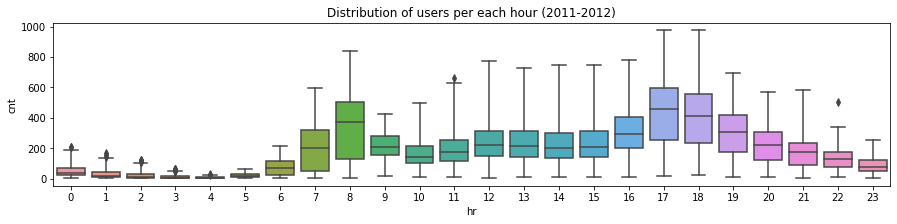

In [15]:
plt.figure(figsize=(15, 3))
ax = sns.boxplot(data = train_hour, x = 'hr', y = 'cnt', whis = 3, showfliers = True)
ax.set(title='Distribution of users per each hour (2011-2012)')
plt.show()

Seems like our dataset contains some outliers. Let's analyze outliers by each year separately. 

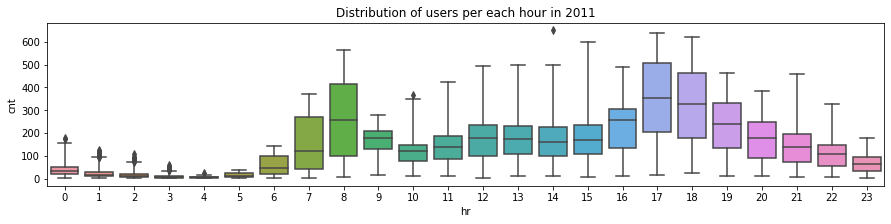

In [16]:
plt.figure(figsize=(15, 3))
ax = sns.boxplot(data=train_hour.loc['2011'], x='hr', y='cnt', whis=3, showfliers=True)
ax.set(title='Distribution of users per each hour in 2011')
plt.show()

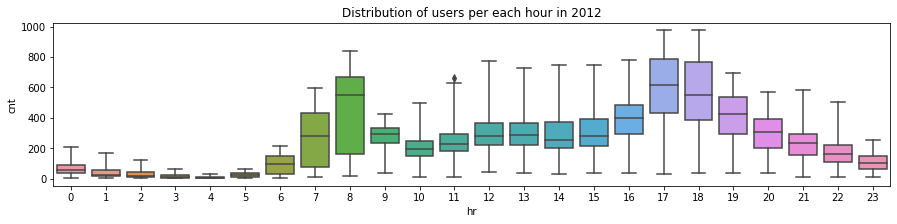

In [17]:
plt.figure(figsize=(15, 3))
ax = sns.boxplot(data=train_hour.loc['2012'], x='hr', y='cnt', whis=3, showfliers=True)
ax.set(title='Distribution of users per each hour in 2012')
plt.show()

##### TODO: add comments on why we are not removing outliers

### Correlations <a id='corr'>

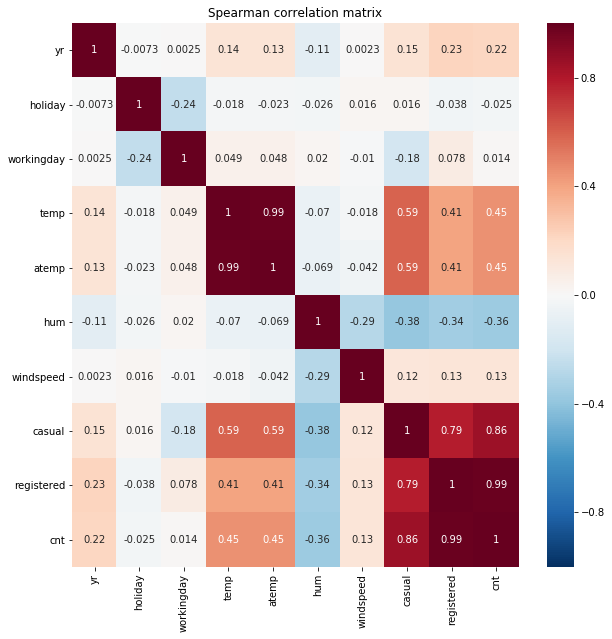

In [18]:
corr_matrix = train_hour.corr(method = 'spearman')
plt.figure(figsize=(10, 10))
ax = sns.heatmap(data = corr_matrix, cmap = "RdBu_r", annot=True, vmin=-1, vmax=1)
ax.set(title='Spearman correlation matrix')
plt.show()

#### Comments: 
From this correlation matrix, we can see that "temp" and "atemp" are highly correlated (0.99): we should either combine them or drop one of it. We also see that "registered" and target variable "cnt" are highly correlated (0.99).

Let's drop "temp" from our dataset during training. 

## Machine Learning (Predictive Analytics) <a id='ml'>

### Linear model: ElasticNet <a id='linear'>

#### Modeling without "casual" and "registered". 

Import model from memory (recommended)

In [7]:
elasticCV = load('models/linear_model.joblib')

# pipeline for transformations
pipeline_poly = Pipeline([
    ('new_features', AddNewFeatures()),
    ('dummy', Dummification()),
    ('minmax_scaler', MinMaxScaler()),
    ('polynomials', PolynomialFeatures(degree=2))
])

X = train_hour.drop(['temp','casual', 'registered', 'cnt'], axis=1)

pipeline_poly.fit(X);

Retrain the model (takes time):

In [ ]:
# pipeline for transformations
pipeline_poly = Pipeline([
    ('new_features', AddNewFeatures()),
    ('dummy', Dummification()),
    ('minmax_scaler', MinMaxScaler()),
    ('polynomials', PolynomialFeatures(degree=2))
])

X = train_hour.drop(['temp','casual', 'registered', 'cnt'], axis=1)
y = train_hour.cnt

# transform the input X
X_prep = pipeline_poly.fit_transform(X)

# ElasticNet model with various L1_ratio that will find the best alpha hyperparameter using cross-validation = 5
elasticCV = ElasticNetCV(l1_ratio = [.7, .9, .95, 1], cv=10, n_jobs=-1, max_iter=2000)

# fitting the model
elasticCV.fit(X_prep,y)

# saving the model to local storage for future retrieval
dump(elasticCV, 'models/linear_model.joblib') 

# printing the R2 score on train set
print('R2 (train): ', elasticCV.score(X_prep,y))

# printing RMSE score on train set
print('RMSE (train): ', np.sqrt(mse(y, elasticCV.predict(X_prep))))

# printing best alpha
print('alpha regularization: ', elasticCV.alpha_)

# printing best L1 ratio
print('L1 ratio: ', elasticCV.l1_ratio_)

#### Comments
The best linear model is given by Lasso (L1 ratio = 1) with alpha regularization of ~0.03: 
1. R2 (train):  0.92
2. RMSE (train):  49.1

Let's check the performance on test set

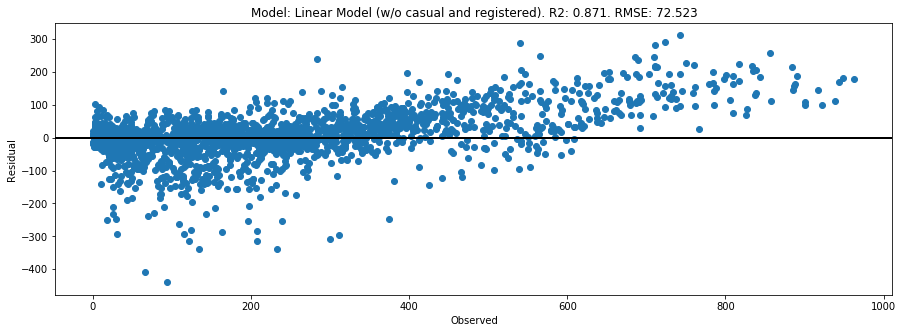

In [8]:
X_test = test_hour.drop(['temp', 'casual', 'registered', 'cnt'], axis=1)
y_test = test_hour.cnt
X_test_prep = pipeline_poly.transform(X_test)
y_test_pred = elasticCV.predict(X_test_prep)

# plotting residuals
residuals = y_test-y_test_pred
r2 = round(elasticCV.score(X_test_prep,y_test), 3)
rmse = round(np.sqrt(mse(y_test, y_test_pred)), 3)

fig, ax = plt.subplots(figsize=(15,5))
ax.scatter(y_test, residuals)
ax.axhline(lw=2,color='black')
ax.set(title=f'Model: Linear Model (w/o casual and registered). R2: {r2}. RMSE: {rmse}', 
       xlabel='Observed', 
       ylabel='Residual')
plt.show()

In [25]:
print(f"Total number of features after all transformations: {elasticCV.coef_.shape[0]}")
print(f"Total number of features that were eliminated by Lasso regularization: {sum(elasticCV.coef_ == 0)}")
print(f"Total number of features that were used by linear model: {sum(elasticCV.coef_ != 0)}")

Total number of features after all transformations: 1653
Total number of features that were eliminated by Lasso regularization: 1086
Total number of features that were used by linear model: 567


#### Modeling without "casual" but with "registered". 

Import model from memory (recommended):

In [27]:
elasticCV_registr = load('models/linear_model_registr.joblib')

# pipeline for transformations
pipeline_poly_registr = Pipeline([
    ('new_features', AddNewFeatures()),
    ('dummy', Dummification()),
    ('minmax_scaler', MinMaxScaler()),
    ('polynomials', PolynomialFeatures(degree=2))
])

X = train_hour.drop(['temp','casual', 'cnt'], axis=1)
pipeline_poly_registr.fit(X);

Retrain the model (takes time):

In [ ]:
# pipeline for transformations
pipeline_poly_registr = Pipeline([
    ('new_features', AddNewFeatures()),
    ('dummy', Dummification()),
    ('minmax_scaler', MinMaxScaler()),
    ('polynomials', PolynomialFeatures(degree=2))
])

X = train_hour.drop(['temp','casual', 'cnt'], axis=1)
y = train_hour.cnt

# transform the input X
X_prep = pipeline_poly_registr.fit_transform(X)

# ElasticNet model with various L1_ratio that will find the best alpha hyperparameter using cross-validation = 5
elasticCV_registr = ElasticNetCV(l1_ratio = [.7, .9, .95, 1], cv=10, n_jobs=-1)

# fitting the model
elasticCV_registr.fit(X_prep,y)

# saving the model to local storage for future retrieval
dump(elasticCV_registr, 'models/linear_model_registr.joblib') 

# printing the R2 score on train set
print('R2 (train): ', elasticCV_registr.score(X_prep,y))

# printing RMSE score on train set
print('RMSE (train): ', np.sqrt(mse(y, elasticCV_registr.predict(X_prep))))

# printing best alpha
print('alpha regularization: ', elasticCV_registr.alpha_)

# printing best L1 ratio
print('L1 ratio: ', elasticCV_registr.l1_ratio_)

#### Comments
The best linear model is given by Lasso (L1 ratio = 1) with alpha regularization of ~0.03: 
1. R2 (train):  0.99
2. RMSE (train):  17.76

Let's check the performance on test set

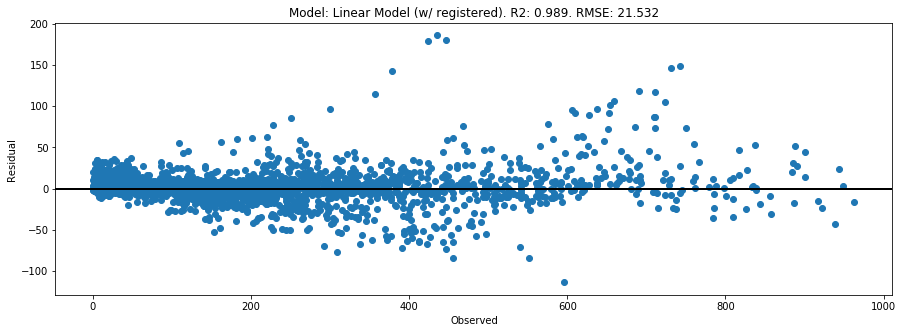

In [48]:
X_test = test_hour.drop(['temp', 'casual', 'cnt'], axis=1)
y_test = test_hour.cnt
X_test_prep = pipeline_poly_registr.transform(X_test)
y_test_pred = elasticCV_registr.predict(X_test_prep)

# plotting residuals
residuals = y_test-y_test_pred
r2 = round(elasticCV_registr.score(X_test_prep,y_test), 3)
rmse = round(np.sqrt(mse(y_test, y_test_pred)), 3)

fig, ax = plt.subplots(figsize=(15,5))
ax.scatter(y_test, residuals)
ax.axhline(lw=2,color='black')
ax.set(title=f'Model: Linear Model (w/ registered). R2: {r2}. RMSE: {rmse}', 
       xlabel='Observed', 
       ylabel='Residual')
plt.show()

In [49]:
print(f"Total number of features after all transformations: {elasticCV_registr.coef_.shape[0]}")
print(f"Total number of features that were eliminated by Lasso regularization: {sum(elasticCV_registr.coef_ == 0)}")
print(f"Total number of features that were used by linear model: {sum(elasticCV_registr.coef_ != 0)}")

Total number of features after all transformations: 1711
Total number of features that were eliminated by Lasso regularization: 1476
Total number of features that were used by linear model: 235


#### Final comments

Adding 'registered' feature in the training (0.99 correlated with target 'cnt') has significantly increased our performance. 

### Tree-based model: Decision Tree <a id='tree'>

#### Modeling without "casual" and "registered". 

Import model from memory (recommended):

In [51]:
best_tree = load('models/decision_tree.joblib')

# pipeline for transformations
pipeline_tree = Pipeline([
    ('new_features', AddNewFeatures()),
    ('dummy', Dummification())
])

X = train_hour.drop(['temp','casual', 'registered', 'cnt'], axis=1)

pipeline_tree.fit(X);

Retrain the model (takes time):

In [ ]:
# pipeline for transformations
pipeline_tree = Pipeline([
    ('new_features', AddNewFeatures()),
    ('dummy', Dummification())
])

X = train_hour.drop(['temp','casual', 'registered', 'cnt'], axis=1)
y = train_hour.cnt

# transform the input X
X_prep = pipeline_tree.fit_transform(X)

# Decision Tree model
tree_reg = DecisionTreeRegressor()

# GridSearchCV to find the best hyperparameters based on cross-validation
param_grid_tree = {
    "min_samples_split": [2, 10, 20, 40],
    "max_depth": [10, 20, None],
    "min_samples_leaf": [1, 20, 40, 100],
    "max_leaf_nodes": [5, 20, 100, None]
}

grid_search_tree = GridSearchCV(tree_reg, cv=10, param_grid=param_grid_tree, n_jobs=-1)

# fitting the model
grid_search_tree.fit(X_prep,y)

# saving the model to local storage for future retrieval
best_tree = grid_search_tree.best_estimator_
dump(best_tree, 'models/decision_tree.joblib') 

# printing the R2 score on train set
print('R2 (train): ', best_tree.score(X_prep,y))

# printing RMSE score on train set
print('RMSE (train): ', np.sqrt(mse(y, best_tree.predict(X_prep))))

# printing top CV results
parameters = ['rank_test_score', 'mean_test_score', 'param_max_depth',
                    'param_max_leaf_nodes', 'param_min_samples_leaf', 'param_min_samples_split']
grid_cv_results_tree = pd.DataFrame(grid_search_tree.cv_results_)[parameters].sort_values('rank_test_score')
print('Grid Search CV results: \n', grid_cv_results_tree.head())

#### Comments
The Decision Tree model performs better than our linear model:
1. R2 (train):  0.92
2. RMSE (train):  57.50
3. R2 (validation): 0.63

However, by comparing with CV results (mean_test_score = R2 of validation), we can see that our model is overfitted. Let's check the performance on test set

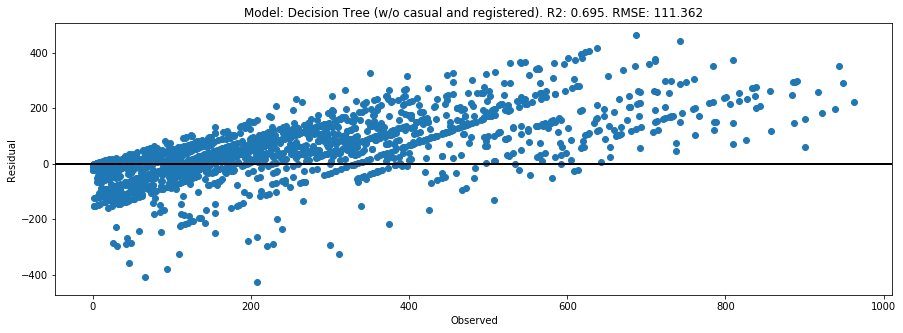

In [52]:
X_test = test_hour.drop(['temp', 'casual', 'registered', 'cnt'], axis=1)
y_test = test_hour.loc[:, 'cnt']
X_test_prep = pipeline_tree.transform(X_test)
y_test_pred = best_tree.predict(X_test_prep)

residuals = y_test-y_test_pred
r2 = round(best_tree.score(X_test_prep,y_test), 3)
rmse = round(np.sqrt(mse(y_test, y_test_pred)), 3)

fig, ax = plt.subplots(figsize=(15,5))
ax.scatter(y_test, residuals)
ax.axhline(lw=2,color='black')
ax.set(title=f'Model: Decision Tree (w/o casual and registered). R2: {r2}. RMSE: {rmse}', 
       xlabel='Observed', 
       ylabel='Residual')
plt.show()

#### Modeling without "casual" but with "registered".

Import model from memory (recommended):

In [54]:
best_tree_registr = load('models/decision_tree_registr.joblib')

# pipeline for transformations
pipeline_tree_registr = Pipeline([
    ('new_features', AddNewFeatures()),
    ('dummy', Dummification())
])

X = train_hour.drop(['temp','casual', 'cnt'], axis=1)

pipeline_tree_registr.fit(X);

Retrain the model (takes time):

In [ ]:
# pipeline for transformations
pipeline_tree_registr = Pipeline([
    ('new_features', AddNewFeatures()),
    ('dummy', Dummification())
])

X = train_hour.drop(['temp','casual', 'cnt'], axis=1)
y = train_hour.cnt

# transform the input X
X_prep = pipeline_tree_registr.fit_transform(X)

# Decision Tree model
tree_reg_registr = DecisionTreeRegressor()

# GridSearchCV to find the best hyperparameters based on cross-validation
param_grid_tree = {
    "min_samples_split": [2, 10, 20, 40],
    "max_depth": [10, 20, None],
    "min_samples_leaf": [1, 20, 40, 100],
    "max_leaf_nodes": [5, 20, 100, None]
}

grid_search_tree_registr = GridSearchCV(tree_reg_registr, cv=10, param_grid=param_grid_tree, n_jobs=-1)

# fitting the model
grid_search_tree_registr.fit(X_prep,y)

# saving the model to local storage for future retrieval
best_tree_registr = grid_search_tree_registr.best_estimator_
dump(best_tree_registr, 'models/decision_tree_registr.joblib') 

# printing the R2 score on train set
print('R2 (train): ', best_tree_registr.score(X_prep,y))

# printing RMSE score on train set
print('RMSE (train): ', np.sqrt(mse(y, best_tree_registr.predict(X_prep))))

# printing top CV results
parameters = ['rank_test_score', 'mean_test_score', 'param_max_depth',
                    'param_max_leaf_nodes', 'param_min_samples_leaf', 'param_min_samples_split']
grid_cv_results_tree = pd.DataFrame(grid_search_tree_registr.cv_results_)[parameters].sort_values('rank_test_score')
print('Grid Search CV results: \n', grid_cv_results_tree.head())

#### Comments
The Decision Tree model performs better than our linear model:
1. R2 (train):  0.99
2. RMSE (train):  19.14
3. R2 (validation): 0.97

R2 on validation is amazing. We suspect including "registered" as a feature is a sort of target leakage. Let's check the performance on test set.  

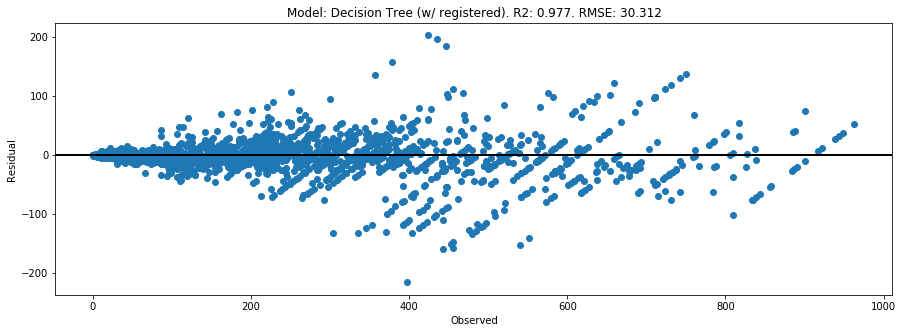

In [55]:
X_test = test_hour.drop(['temp', 'casual', 'cnt'], axis=1)
y_test = test_hour.loc[:, 'cnt']
X_test_prep = pipeline_tree_registr.transform(X_test)
y_test_pred = best_tree_registr.predict(X_test_prep)

# plotting residuals
residuals = y_test-y_test_pred
r2 = round(best_tree_registr.score(X_test_prep,y_test), 3)
rmse = round(np.sqrt(mse(y_test, y_test_pred)), 3)

fig, ax = plt.subplots(figsize=(15,5))
ax.scatter(y_test, residuals)
ax.axhline(lw=2,color='black')
ax.set(title=f'Model: Decision Tree (w/ registered). R2: {r2}. RMSE: {rmse}', 
       xlabel='Observed', 
       ylabel='Residual')
plt.show()

### Tree-based model: Random Forest <a id='forest'>

#### Modeling without "casual" and "registered"

Import model from memory (recommended):

In [56]:
best_rf = load('models/random_forest.joblib')

# pipeline for transformations
pipeline_forest = Pipeline([
    ('new_features', AddNewFeatures()),
    ('dummy', Dummification())
])

X = train_hour.drop(['temp', 'casual', 'registered', 'cnt'], axis=1)

pipeline_forest.fit(X);

Retrain the model (takes time):

In [ ]:
# pipeline for transformations
pipeline_forest = Pipeline([
    ('new_features', AddNewFeatures()),
    ('dummy', Dummification())
])

X = train_hour.drop(['temp', 'casual', 'registered', 'cnt'], axis=1)
y = train_hour.cnt

# transform the input X
X_prep = pipeline_forest.fit_transform(X)

# Random Forest model
rf_reg = RandomForestRegressor()

# GridSearchCV to find the best hyperparameters based on cross-validation
param_grid_forest = {
    "min_samples_split": [4,20,100],
    "max_depth": [10, 25, 50],
    "n_estimators": [50, 100]}

grid_search_forest = GridSearchCV(rf_reg, cv=10, param_grid=param_grid_forest, n_jobs=-1)

# fitting the model
grid_search_forest.fit(X_prep,y)

# saving the model to local storage for future retrieval
best_rf = grid_search_forest.best_estimator_
dump(best_rf, 'models/random_forest.joblib') 

# printing the R2 score on train set
print('R2 (train): ', best_rf.score(X_prep,y))

# printing RMSE score on train set
print('RMSE (train): ', np.sqrt(mse(y, best_rf.predict(X_prep))))

# printing top CV results
parameters = ['rank_test_score', 'mean_test_score', 'param_max_depth',
              'param_n_estimators', 'param_min_samples_split']
grid_cv_results_forest = pd.DataFrame(grid_search_forest.cv_results_)[parameters].sort_values('rank_test_score')
print('CV results: \n', grid_cv_results_forest.head())

#### Comments
The Random Forest model performs even better than our Decision Tree model:
1. R2 (train):  ~0.98
2. RMSE (train):  ~21
3. R2 (validation): ~0.74

However, by comparing with CV results (mean_test_score = R2 of validation), we can see that our model is also overfitted.

Given that Random Forest performs better than Decision Tree, let's continue iterating with this algorithm and try to fix overfitting problem. 
There are several ways to do that:
1. Adding more training data
2. Adding more regularization (hyperparameters tuning)
3. Reducing number of features. 

Since we cannot add training data and we are already using cross-validation to find the best hyperparameters, let's try to fix overfitting by reducing number of features. We have created some features before and now it is time to check if those are significant.

#### Feature importance

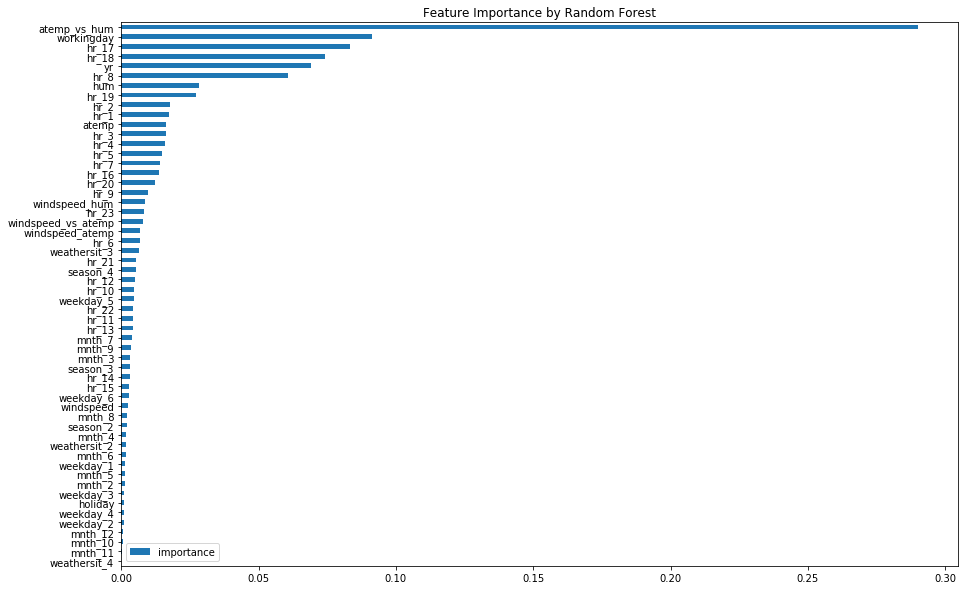

In [57]:
transformation = Pipeline([
    ('new_features', AddNewFeatures()),
    ('dummy', Dummification())
])

X = train_hour.drop(['temp','casual', 'registered', 'cnt'], axis=1)
X_transformed = transformation.fit_transform(X)

feature_names = X_transformed.columns
feature_importance = pd.DataFrame({'importance': best_rf.feature_importances_}, index=feature_names).sort_values('importance')
feature_importance.plot.barh(y='importance', figsize=(15,10), title='Feature Importance by Random Forest')
plt.show()

### Iterations: Random Forest <a id='iteration'>

#### Iterations: 
1. TBD

Any iterations with features to drop and/or not to include make our model worse both in terms of R2 and RMSE. The code below allows to play with iterations. 

Transformations that should be used for iterating with variables are <strong>AddNewFeatures()</strong> and <strong>DropColumns()</strong>. Original features can be dropped using <strong>DropColumns(feature=True)</strong>, while newly generated features should be excluded by <strong>AddNewFeatures(feature=False). 

#### Model

In [ ]:
# pipeline for transformation
pipeline_forest_iter = Pipeline([
    ('new_features', AddNewFeatures()),
    ('drop_cols', DropColumns(holiday=True)),
    ('dummy', Dummification())
])

X = train_hour.drop(['temp','casual', 'registered', 'cnt'], axis=1)
y = train_hour.cnt

# transform the input X
X_prep = pipeline_forest_iter.fit_transform(X)

# Random Forest model
rf_reg_iter = RandomForestRegressor()

# GridSearchCV to find the best hyperparameters based on cross-validation
param_grid_forest_iter = {
    "min_samples_split": [4,20,100],
    "max_depth": [10, 25, 50],
    "n_estimators": [50, 100]}

grid_search_forest_iter = GridSearchCV(rf_reg_iter, cv=10, param_grid=param_grid_forest_iter, n_jobs=-1)

# fitting the model
grid_search_forest_iter.fit(X_prep,y)

# printing the R2 score on train set
print('R2 (train): ', grid_search_forest_iter.best_estimator_.score(X_prep,y))

# printing RMSE score on train set
print('RMSE (train): ', np.sqrt(mse(y, grid_search_forest_iter.predict(X_prep))))

# printing top CV results
parameters = ['rank_test_score', 'mean_test_score', 'param_max_depth',
              'param_n_estimators', 'param_min_samples_split']
grid_cv_results_forest_iter = pd.DataFrame(grid_search_forest_iter.cv_results_)[parameters].sort_values('rank_test_score')
print('CV results: \n', grid_cv_results_forest_iter.head())

#### Feature Importance

In [ ]:
best_rf_iter = grid_search_forest_iter.best_estimator_

transformation_iter = Pipeline([
    ('new_features', AddNewFeatures()),
    ('drop_cols', DropColumns(holiday=True)),
    ('dummy', Dummification())
])

X = train_hour.drop(['temp','casual', 'registered', 'cnt'], axis=1)
X_transformed = transformation_iter.fit_transform(X)

feature_names = X_transformed.columns
feature_importance = pd.DataFrame({'importance': best_rf_iter.feature_importances_}, index=feature_names).sort_values('importance')
feature_importance.plot.barh(y='importance', figsize=(15,10), title='Feature Importance by Random Forest (iteration)')
plt.show()

#### Performance on test set

In [ ]:
best_rf_iter = grid_search_forest_iter.best_estimator_

X_test = test_hour.drop(['temp','casual', 'registered', 'cnt'], axis=1)
y_test = test_hour.loc[:, 'cnt']
X_test_prep = pipeline_forest_iter.transform(X_test)

# printing the R2 score on test set
print('R2 (test): ', best_rf_iter.score(X_test_prep,y_test))

# printing RMSE score on test set
print('RMSE (test): ', np.sqrt(mse(y_test, best_rf_iter.predict(X_test_prep))))

## Work description <a id='work'>

The first step was to import the data and then split it so that the train set contained the first year and the first three quarters  of the second year, and the test set contained the fourth quarter of the second year.

Exploratory Data Analysis
The data was then visualized by plotting the total count vs hour for each day of the week. This was done to see the influence of hour and week day on bike usage.
Then two more graphs were plotted with the same format as the first, but this time users were divided into casual and registered. This visualization showed that casual users are more active during weekends and the middle of the day, while registered users are more active during weekdays, specifically during commuting hours. It was also noted that total count as increased between years 1 and 2.
The next step was to ensure data quality. This involved checking for duplicates and removing them, checking for null values (none were found), checking for any data errors (none were found) and checking for outliers. For the outliers, a boxplot was used to show the entire dataset, and then two more boxplots were created, one for 2011 and the other for 2012. In this way, most of the outliers were to be found in 2011. The decision was made to keep these, in order to avoid losing important information from the dataset.
A heatmap was then produced in order to reveal correlations between the predictor variables and the target variable. In this way, temp and atemp were found to be highly correlated, so the decision was taken to drop temp, since ‘feeling temperature’ was deemed to be a more important factor in a customer’s decision-making process than overall temperature. Since casual and registered are both related to total count, in the sense that they both directly contribute to total count, the decision was taken to drop them. Using them for predictions is similar to using information from the future, which would rarely be possible in a real-world scenario. Meanwhile four new features were added. These included: ratio of atemp to humidity, ratio of wind speed to atemp, product of wind speed and humidity, and product of wind speed and humidity.

Machine Learning
First an elastic net was run. A 10-fold cross validation was used with various L1 ratios to find the best alpha hyperparameter and L1 ratio. The best results were an L1 of 1 and an alpha ratio of 0.023. The L1 ratio implied that a pure lasso model was the best option, and so this was run on the test set obtaining an R2 of 0.871, and an RMSE of 72.523. The procedure was repeated, but this time the registered column was added to the data. A lasso was again run, this time obtaining and R2 of 0.989 and an RMSE of 21.532; this was obviously a great improvement on the previous results, which was due to using the future information from the target variable in order to predict it; again, this would likely not be available in a real world situation.
Next, a decision tree was used to run the same process, with a grid search used to find the best hyperparameters using cross validation. With the registered column excluded, an R2 of 0.695 and an RMSE of 111.362 was obtained; with it included the R2 was 0.977 and the RMSE was 30.312.
In conclusion, the lasso performed significantly better than the decision tree.
A random forest was then used with a grid search to find the best hyperparameters. Random forest was used to calculate the feature importance, with the most important being the ratio of atemp to humidity. The next most important features are the time-based ones; this fit with previous findings, where the number of bikes used depended on the time and day of the week. Running the random forest on the test set obtained an R2 of 0.776 and an RMSE of 95.24, thus this performs poorly in comparison to the Lasso.

Conclusion
Stepping back from the problem, the dataset is a typical time series dataset. In this project, machine learning models were used to forecast but in reality, different methods would be more appropriate, since they would be able to take into account the influence of the past on the future. In the process of carrying out this assignment, the work was divided as follows. All of the team members took part in the feature engineering by creating new features and testing them, the four best features were then selected. The machine learning process was conducted as a team, with all team members puzzling through the correct procedures together, coding different parts.
